In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer

from sklearn.metrics import confusion_matrix as cm
from sklearn.model_selection import cross_val_score

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

import xgboost as xgb
import graphviz

In [3]:
production = pd.read_sas('C:/Users/kucza/OneDrive/Desktop/DataScience/CreditScoringPython/dane/production.sas7bdat',
                        format = 'sas7bdat',
                         encoding="ISO-8859-1" )
transactions = pd.read_sas('C:/Users/kucza/OneDrive/Desktop/DataScience/CreditScoringPython/dane/transactions.sas7bdat',
                        format = 'sas7bdat',
                         encoding="ISO-8859-1" )

In [3]:
production.head()

,cid,aid,product,period,act_age,act_cc,act_loaninc,app_income,app_loan_amount,app_n_installments,...,act_CIns_All5y,act_CAll_Acp5y,act_CAll_All5y,APP_CHAR_GENDER,APP_CHAR_CITY,APP_CHAR_BRANCH,APP_CHAR_JOB_CODE,APP_CHAR_CARS,APP_CHAR_HOME_STATUS,APP_CHAR_MARITAL_STATUS
0,0000001237,css2006010100123,css,200601,84.0,0.577685,2.606882,1918.0,5000.0,24.0,...,1.0,7.0,15.0,1.0,0.0,0.0,4.0,1.0,0.0,2.0
1,0000003380,css2006010100350,css,200601,87.0,0.499747,2.529084,1977.0,5000.0,24.0,...,NaN,14.0,15.0,1.0,3.0,0.0,4.0,0.0,0.0,1.0
2,0000003467,css2006010100357,css,200601,75.0,0.584158,4.125413,1212.0,5000.0,24.0,...,1.0,16.0,16.0,1.0,1.0,0.0,4.0,1.0,0.0,1.0
3,0000003620,css2006010100367,css,200601,94.0,0.602687,4.798464,1042.0,5000.0,24.0,...,NaN,14.0,15.0,1.0,0.0,0.0,4.0,1.0,0.0,0.0
4,0000003621,css2006010100368,css,200601,70.0,0.604592,3.188776,1568.0,5000.0,24.0,...,NaN,15.0,15.0,1.0,0.0,0.0,4.0,1.0,0.0,1.0


In [31]:
transactions.head()

,cid,aid,product,period,fin_period,status,due_installments,paid_installments,leftn_installments
0,0000000002,css2006010500001,css,200601,200601,A,0.0,0.0,24.0
1,0000000002,css2006010500001,css,200602,200601,A,0.0,1.0,23.0
2,0000000002,css2006010500001,css,200603,200601,A,0.0,2.0,22.0
3,0000000002,css2006010500001,css,200604,200601,A,0.0,3.0,21.0
4,0000000002,css2006010500001,css,200605,200601,A,0.0,4.0,20.0


Default definition: if a product ever has n_installments_due or more it is considered as default, no matter if the client pays the loan back at a later time.

In [4]:
############## PROBLEM SPECIFIC FUNCTIONS ###########################
def MaxDueInstallmentsMinPeriod(data_transactions):
    #Creating table with product id, first installment period adn max due installements.
    max_due_install_min_period = pd.pivot_table(data = data_transactions, index = 'aid',
                                            values = ['due_installments', 'period'], aggfunc = ['max', 'min'])
    max_due_install_min_period.columns = ['max_due_installments', 'max_period', 'min_due_installments', 'min_period']
    max_due_install_min_period.drop(['max_period', 'min_due_installments'], axis = 1, inplace = True)
    max_due_install_min_period['min_period'] = pd.to_numeric(max_due_install_min_period['min_period'])
    return max_due_install_min_period

def DefaultPerProduct(data_product, n_installments_due = 3, max_period = 200712):
    #Creating dataframe with 0-1 variable if the product defaulted
    col_name = 'default'+str(n_installments_due)
    data_product.insert(len(data_product.columns),col_name, 0)
    for index, row in data_product.iterrows():        
        if row['max_due_installments'] >= n_installments_due and row['min_period'] <= max_period:
            data_product.at[index, col_name] = 1
        else:
            data_product.at[index, col_name] = 0
    data_product.drop(['min_period', 'max_due_installments'], axis = 1, inplace = True)
    return data_product

def ProductionDefault(data_product_default, data_production):
    #Adding col1umn with 0-1 default to the main dataframe
    data_production['period'] = pd.to_numeric(data_production['period'])
    data_production = data_production[data_production['period'] <= 200712]
    data_merged = data_production.merge(right = data_product_default, on = 'aid')
    return data_merged

############## PREPORCESSING FUNCTIONS ###########################

def unique_count(dataframe):
    uniques = dataframe.from_records([(col, dataframe[col].nunique()) for col in dataframe.columns], 
                                        columns=['Column_Name', 'Num_Unique']).sort_values(by=['Num_Unique'])
    return uniques

def DeleteMissing(dataframe, perc_missing_delete = 0.6):
    return_df = dataframe[dataframe.columns[dataframe.isnull().mean() <= perc_missing_delete]]
    return return_df

def get_column_names_from_ColumnTransformer(column_transformer):    
    col_name = []
    for transformer_in_columns in column_transformer.transformers_[:-1]:#the last transformer is ColumnTransformer's 'remainder'
        raw_col_name = transformer_in_columns[1]
        if isinstance(transformer_in_columns[1],Pipeline): 
            transformer = transformer_in_columns[1].steps[-1][1]
        else:
            transformer = transformer_in_columns[1]
        try:
            names = transformer.get_feature_names()
        except AttributeError: # if no 'get_feature_names' function, use raw column name
            names = raw_col_name
        if isinstance(names,np.ndarray): # eg.
            col_name += names.tolist()
        elif isinstance(names,list):
            col_name += names    
        elif isinstance(names,str):
            col_name.append(names)
    return col_name

def Imputer_df(dataframe, num_cols_names, cat_cols_names, strategy_num_cols = 'mean',
               strategy_cat_cols = 'most_frequent', remainder = 'passthrough'):
    
    #imputes missing values using SimpleImputer from sklearn and returns a dataframe instead of numpy array
    from sklearn.impute import SimpleImputer
    
    names = num_cols+cat_cols+[name for name in dataframe.columns if name not in num_cols+cat_cols]
    ct1 = ColumnTransformer([
        ('imput_mean', SimpleImputer(strategy = strategy_num_cols), num_cols),
        ('imput_most_freq', SimpleImputer(strategy = strategy_cat_cols), cat_cols)
        ], remainder = 'passthrough')
    return_df = pd.DataFrame(data = ct1.fit_transform(dataframe), columns = names)
    return return_df


def ColumnValuesCheck(df1, df2):
    # Columns in both dataframes must have the same names
    #checks if columns with the same names have the same values. Columns do not have to be in the same order
    #DO NOT USE AFTER IMPUTING MISSING VALUES
    list = []
    for column in df1:
        column_values1 = df1[column]
        column_values2 = df2[column]
        if column_values1.equals(column_values2):
            list = list + [1]
        else:
            list = list + [0]
    return list

In [60]:
#transformer_in_columns = transformer.transformers_[:-1]
#raw_col_name = transformer_in_columns[1]
#raw_col_name[1].get_feature_names()

In [5]:
data = MaxDueInstallmentsMinPeriod(transactions)
def_product = DefaultPerProduct(data, 3, 200712)
data_merged = ProductionDefault(def_product, production)
data_merged_nomisscol = DeleteMissing(data_merged, 0.6)

In [6]:
data_css = data_merged_nomisscol[data_merged_nomisscol['product'] == 'css']

In [7]:
data_css_select = data_css.iloc[:,5:29].copy()

In [8]:
data_css_default3 = data_css.loc[:,'default3'].values
y = data_css_default3.copy()

In [92]:
data_css_select.head()

,act_cc,act_loaninc,app_income,app_loan_amount,app_n_installments,app_number_of_children,app_spendings,app_installment,act_call_cc,act_cins_n_loan,...,act_cins_n_loans_hist,act_cins_n_statC,act_cins_n_statB,act_ccss_seniority,act_ccss_min_seniority,act_ccss_n_loans_hist,act_ccss_n_statC,act_ccss_n_statB,act_cus_active,act_CMaxA_Days
0,0.577685,2.606882,1918.0,5000.0,24.0,0.0,900.0,208.0,1.119917,0.0,...,21.0,21.0,0.0,307.0,4.0,51.0,43.0,2.0,1.0,15.0
1,0.499747,2.529084,1977.0,5000.0,24.0,0.0,780.0,208.0,1.025797,0.0,...,9.0,6.0,3.0,252.0,4.0,40.0,32.0,2.0,1.0,14.0
2,0.584158,4.125413,1212.0,5000.0,24.0,0.0,500.0,208.0,1.442244,0.0,...,6.0,6.0,0.0,309.0,4.0,76.0,70.0,0.0,1.0,14.0
3,0.602687,4.798464,1042.0,5000.0,24.0,0.0,420.0,208.0,1.401152,0.0,...,11.0,11.0,0.0,299.0,4.0,69.0,62.0,2.0,1.0,15.0
4,0.604592,3.188776,1568.0,5000.0,24.0,0.0,740.0,208.0,1.267857,0.0,...,11.0,11.0,0.0,307.0,4.0,69.0,62.0,1.0,1.0,14.0


In [95]:
unique_count(data_css_select)

,Column_Name,Num_Unique
22,act_cus_active,1
3,app_loan_amount,1
4,app_n_installments,1
7,app_installment,1
5,app_number_of_children,4
9,act_cins_n_loan,4
10,act_ccss_n_loan,7
11,act_call_n_loan,8
16,act_cins_n_statB,22
23,act_CMaxA_Days,25


C:\Anaconda\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Anaconda\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


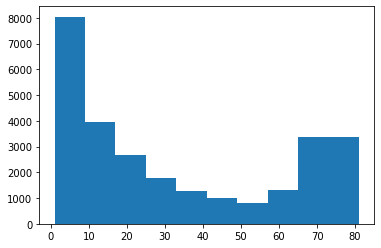

In [96]:
plt.hist(data_css_select['act_ccss_n_loans_hist'])
plt.show()

In [9]:
drop_cols = unique_count(data_css_select)['Column_Name'][0:4].values.tolist()
cat_cols = unique_count(data_css_select)['Column_Name'][4:8].values.tolist()
num_cols = unique_count(data_css_select)['Column_Name'][8:23].values.tolist()

In [10]:
ct1 = ColumnTransformer([
    ('imput_mean', SimpleImputer(strategy = 'mean'), num_cols),
    ('imput_most_freq', SimpleImputer(strategy = 'most_frequent'), cat_cols)
], remainder = 'drop')

In [11]:
ct2 = ColumnTransformer([
    ('stand_scale', StandardScaler(), num_cols),
    ('ohe', OneHotEncoder(categories = 'auto'), cat_cols)
], remainder = 'drop')

In [32]:
pipeline = Pipeline([
    ('column transformer', transformer),
    ('ling_reg', LogisticRegression())    
])

In [83]:
#pipeline.fit(data_css_select, y_train)

In [99]:
ColumnValuesCheck(data_X, data_css_select)

[1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [14]:
data_X = Imputer_df(dataframe = data_css_select, num_cols_names = num_cols, cat_cols_names = cat_cols)

In [16]:
data_X_scaled_onehot = ct2.fit_transform(data_X)

In [17]:
print(data_X_scaled_onehot)

[[-0.27750626  0.71527406  3.54509451 ...  1.          0.
   0.        ]
 [ 2.15028684  0.1787084   0.11677979 ...  1.          0.
   0.        ]
 [-0.27750626  0.1787084   0.11677979 ...  1.          0.
   0.        ]
 ...
 [-0.27750626  0.71527406 -1.02599178 ...  0.          0.
   0.        ]
 [-0.27750626 -0.35785726 -1.25454609 ...  0.          0.
   0.        ]
 [-0.27750626 -0.89442292 -1.25454609 ...  0.          0.
   0.        ]]


In [29]:
X_train, X_test, y_train, y_test = train_test_split(data_X_scaled_onehot, y, test_size = 0.2, random_state = 0)

## Gradient Boosting

In [42]:
dtrain = xgb.DMatrix(X_train, label = y_train)
dtest = xgb.DMatrix(X_test, label = y_test)

In [78]:
param = {'max_depth': 8,
        'learning_rate': 1,
        'objective': 'binary:logistic',
        'nthread': 4,
        'eval_metric': ['auc', 'error']}
evallist = [(dtrain, 'eval',
            dtest, 'train')]
num_round = 100


In [79]:
bst = xgb.train(param, dtrain, num_round, evallist)

[0]	eval-auc:0.80822	eval-error:0.20321
[1]	eval-auc:0.84333	eval-error:0.18758
[2]	eval-auc:0.85617	eval-error:0.18102
[3]	eval-auc:0.87277	eval-error:0.17263
[4]	eval-auc:0.87704	eval-error:0.17012
[5]	eval-auc:0.88684	eval-error:0.16401
[6]	eval-auc:0.89580	eval-error:0.15801
[7]	eval-auc:0.90664	eval-error:0.14874
[8]	eval-auc:0.91263	eval-error:0.14522
[9]	eval-auc:0.91729	eval-error:0.14064
[10]	eval-auc:0.92224	eval-error:0.13789
[11]	eval-auc:0.92739	eval-error:0.13303
[12]	eval-auc:0.93215	eval-error:0.12825
[13]	eval-auc:0.94044	eval-error:0.11873
[14]	eval-auc:0.94460	eval-error:0.11387
[15]	eval-auc:0.94700	eval-error:0.11112
[16]	eval-auc:0.95095	eval-error:0.10731
[17]	eval-auc:0.95344	eval-error:0.10525
[18]	eval-auc:0.95913	eval-error:0.09784
[19]	eval-auc:0.96217	eval-error:0.09363
[20]	eval-auc:0.96346	eval-error:0.09128
[21]	eval-auc:0.96481	eval-error:0.08941
[22]	eval-auc:0.96866	eval-error:0.08415
[23]	eval-auc:0.97274	eval-error:0.07727
[24]	eval-auc:0.97452	eval

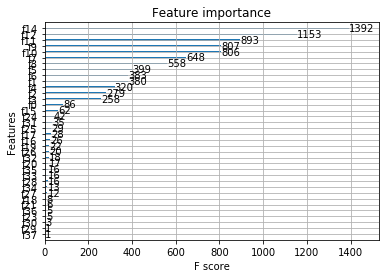

In [81]:
xgb.plot_importance(bst)

In [95]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

ExecutableNotFound: failed to execute ['dot', '-Tpng'], make sure the Graphviz executables are on your systems' PATH

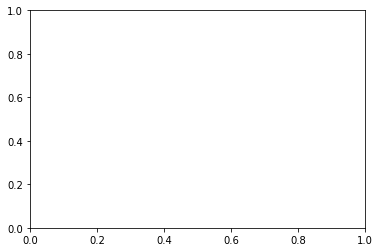

In [96]:
xgb.plot_tree(bst, num_trees=1)

In [87]:
lin_reg = LogisticRegression()
lin_reg.fit(X_train, y_train)

C:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [22]:
y_pred_prob = lin_reg.predict_proba(X_test)
y_pred = lin_reg.predict(X_test)

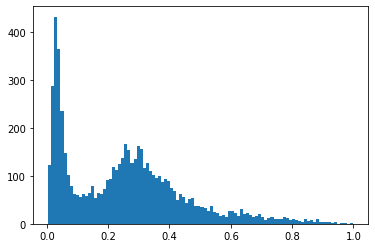

In [23]:
y_pred_prob_plot = [y_pred_prob[i][1] for i in range(len(y_pred_prob))]
plt.hist(y_pred_prob_plot, bins=100)
plt.show()

In [24]:
cv = cross_val_score(lin_reg, data_X, y, cv = 5, scoring = 'f1')

C:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [25]:
print("avg. accuracy = "+str(round(np.mean(cv),4))+
      " std. of accuracy = "+str(round(np.std(cv),4))+
      " std. coef = "+str(round(np.std(cv)/np.mean(cv),4)))

avg. accuracy = 0.3798 std. of accuracy = 0.0063 std. coef = 0.0166


In [26]:
print(cm(y_true = y_test, y_pred = y_pred))

[[4345  237]
 [1164  428]]


In [59]:
get_column_names_from_ColumnTransformer(transformer)

['x0_0.0',
 'x0_1.0',
 'x0_2.0',
 'x0_3.0',
 'x1_0.0',
 'x1_1.0',
 'x1_2.0',
 'x1_3.0',
 'x2_1.0',
 'x2_2.0',
 'x2_3.0',
 'x2_4.0',
 'x2_5.0',
 'x2_6.0',
 'x2_7.0',
 'drop']

In [10]:
data_merged_nomisscol.head()

,cid,aid,product,period,act_age,act_cc,act_loaninc,app_income,app_loan_amount,app_n_installments,...,act_CAll_Acp5y,act_CAll_All5y,APP_CHAR_GENDER,APP_CHAR_CITY,APP_CHAR_BRANCH,APP_CHAR_JOB_CODE,APP_CHAR_CARS,APP_CHAR_HOME_STATUS,APP_CHAR_MARITAL_STATUS,default3
0,0000001237,css2006010100123,css,200601,84.0,0.577685,2.606882,1918.0,5000.0,24.0,...,7.0,15.0,1.0,0.0,0.0,4.0,1.0,0.0,2.0,0
1,0000003380,css2006010100350,css,200601,87.0,0.499747,2.529084,1977.0,5000.0,24.0,...,14.0,15.0,1.0,3.0,0.0,4.0,0.0,0.0,1.0,0
2,0000003467,css2006010100357,css,200601,75.0,0.584158,4.125413,1212.0,5000.0,24.0,...,16.0,16.0,1.0,1.0,0.0,4.0,1.0,0.0,1.0,0
3,0000003620,css2006010100367,css,200601,94.0,0.602687,4.798464,1042.0,5000.0,24.0,...,14.0,15.0,1.0,0.0,0.0,4.0,1.0,0.0,0.0,0
4,0000003621,css2006010100368,css,200601,70.0,0.604592,3.188776,1568.0,5000.0,24.0,...,15.0,15.0,1.0,0.0,0.0,4.0,1.0,0.0,1.0,0


In [173]:
data_merged_nomiss.isna().mean().sort_values(ascending=False)

agr3_Mean_CMaxA_Due     0.588670
agr3_Max_CMaxA_Due      0.588670
agr3_Min_CMaxA_Due      0.588670
act_CMaxA_Days          0.587548
act_cus_active          0.582405
                          ...   
APP_CHAR_BRANCH         0.000000
APP_CHAR_JOB_CODE       0.000000
APP_CHAR_CARS           0.000000
APP_CHAR_HOME_STATUS    0.000000
cid                     0.000000
Length: 85, dtype: float64

In [28]:
plt.hist(data_merged_nomiss.isna().mean().sort_values(ascending=False), bins=100)
plt.show()

NameError: name 'data_merged_nomiss' is not defined

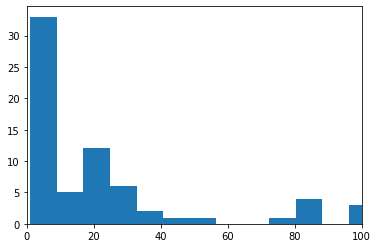

In [14]:
plt.hist(x = unique_count(data_merged_nomiss)['Num_Unique'], bins = 10000)
plt.xlim(0, 100)
plt.show()

In [162]:
len(data_merged)

79328